In [1]:
!pip install -q pennylane scikit-learn matplotlib opencv-python tensorflow
!pip install -q pennylane-lightning-gpu

In [2]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import load_digits
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from itertools import combinations
from typing import List, Tuple
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
class DataEncoder:
    def __init__(
        self,
        dataset_name: str,
        encoding_method: str,
        positive_label: int,
        num_train: int = 100,
        num_test_pos: int = 70,
        num_test_neg: int = 70,
    ):
        """
        DataEncoder class to handle data loading and encoding.

        Args:
            dataset_name (str): Name of the dataset ("Handwritten" or "FMNIST").
            encoding_method (str): Encoding method ("Amplitude" or "FRQI").
            positive_label (int): Label of the positive class for one-class classification.
            num_train (int): Number of positive samples for training.
            num_test_pos (int): Number of positive samples for testing.
            num_test_neg (int): Number of negative samples per class for testing.
        """
        self.dataset_name = dataset_name
        self.encoding_method = encoding_method
        self.positive_label = positive_label
        self.num_train = num_train
        self.num_test_pos = num_test_pos
        self.num_test_neg = num_test_neg
        self.nqubits = None

        self.vector_train = []
        self.vector_test_pos = []
        self.vector_test_neg = []

        self.load_and_encode_data()

    def load_and_encode_data(self):
        if self.dataset_name == "Handwritten":
            data, labels = self.load_handwritten_data()
            self.nqubits = 6 if self.encoding_method == "Amplitude" else 7
        elif self.dataset_name == "FMNIST":
            data, labels = self.load_fmnist_data()
            self.nqubits = 8 if self.encoding_method == "Amplitude" else 9
        else:
            raise ValueError("Supported datasets are 'Handwritten' and 'FMNIST'.")

        # Process and encode data
        self.process_and_encode_data(data, labels)

    def load_handwritten_data(self) -> Tuple[np.ndarray, np.ndarray]:
        digits = load_digits()
        data = digits.data / 16.0  # Normalize data to [0,1]
        labels = digits.target
        return data, labels

    def load_fmnist_data(self) -> Tuple[np.ndarray, np.ndarray]:
        fashion_mnist = tf.keras.datasets.fashion_mnist
        (x_train, y_train), _ = fashion_mnist.load_data()
        x_train = x_train / 255.0  # Normalize data to [0,1]
        x_train = x_train.reshape((-1, 28 * 28))
        data = x_train
        labels = y_train
        return data, labels

    def process_and_encode_data(self, data: np.ndarray, labels: np.ndarray):
        # Get positive and negative samples
        positive_indices = np.where(labels == self.positive_label)[0]
        negative_labels = np.delete(np.unique(labels), self.positive_label)
        negative_indices = np.where(np.isin(labels, negative_labels))[0]

        # Get training data (positive samples)
        idx_train = positive_indices[: self.num_train]
        data_train = data[idx_train]

        # Get positive test data
        idx_test_pos = positive_indices[self.num_train : self.num_train + self.num_test_pos]
        data_test_pos = data[idx_test_pos]

        # Get negative test data
        data_test_neg = []
        for neg_label in negative_labels:
            neg_idx = np.where(labels == neg_label)[0][: self.num_test_neg]
            data_test_neg.append(data[neg_idx])
        data_test_neg = np.vstack(data_test_neg)

        # Resize images for FMNIST dataset
        if self.dataset_name == "FMNIST":
            data_train = self.resize_images(data_train)
            data_test_pos = self.resize_images(data_test_pos)
            data_test_neg = self.resize_images(data_test_neg)

        # Encode data
        self.vector_train = self.encode_data(data_train)
        self.vector_test_pos = self.encode_data(data_test_pos)
        self.vector_test_neg = self.encode_data(data_test_neg)

    def resize_images(self, data: np.ndarray) -> np.ndarray:
        resized_data = []
        for sample in data:
            img = sample.reshape(28, 28)
            resized_img = cv2.resize(img, dsize=(16, 16), interpolation=cv2.INTER_CUBIC)
            resized_data.append(resized_img.flatten())
        return np.array(resized_data)

    def encode_data(self, data: np.ndarray) -> List[np.ndarray]:
        if self.encoding_method == "Amplitude":
            return self.amplitude_encoding(data)
        elif self.encoding_method == "FRQI":
            return self.frqi_encoding(data)
        else:
            raise ValueError("Supported encodings are 'Amplitude' and 'FRQI'.")

    def amplitude_encoding(self, data: np.ndarray) -> List[np.ndarray]:
        # Normalize each data sample
        normalized_data = [sample / np.linalg.norm(sample) for sample in data]
        return normalized_data

    def frqi_encoding(self, data: np.ndarray) -> List[np.ndarray]:
        encoded_data = []
        for sample in data:
            sample = sample.flatten()
            cos_component = np.cos(np.pi / 2 * sample)
            sin_component = np.sin(np.pi / 2 * sample)
            vector = np.concatenate((cos_component, sin_component))
            vector = vector / np.linalg.norm(vector)
            encoded_data.append(vector)
        return encoded_data

In [4]:
class VQOCCircuit:
    def __init__(self, nqubits: int, ntrash: int, layers: int):
        """
        Variational Quantum One-Class Classifier (VQOCC).

        Args:
            nqubits (int): Total number of qubits.
            ntrash (int): Number of trash qubits.
            layers (int): Number of layers in the variational circuit.
        """
        assert ntrash < nqubits, "Number of trash qubits must be less than total qubits."

        self.nqubits = nqubits
        self.ntrash = ntrash
        self.layers = layers

        self.trash_qubits = list(range(nqubits - ntrash, nqubits))
        self.non_trash_qubits = list(range(nqubits - ntrash))

        # Initialize parameters
        self.nparams = self.calculate_num_params()
        self.params = np.random.uniform(size=self.nparams, requires_grad=True)

        # Set up the quantum device (try lightning.gpu or lightning.qubit)
        try:
            self.dev = qml.device("lightning.gpu", wires=nqubits)
            print("Using GPU device")
        except Exception as e:
            print("GPU device setup failed, falling back to lightning.qubit (CPU)")
            self.dev = qml.device("lightning.qubit", wires=nqubits)

    def calculate_num_params(self) -> int:
        # Number of parameters depends on the architecture
        nparams = self.layers * self.nqubits + self.ntrash
        return nparams

    def circuit(self, params: np.ndarray, input_state: np.ndarray = None):
        @qml.qnode(self.dev, interface="autograd")
        def circuit_qnode(params):
            # Prepare the input state
            if input_state is not None:
                qml.QubitStateVector(input_state, wires=range(self.nqubits))
            else:
                for q in range(self.nqubits):
                    qml.Hadamard(wires=q)

            # Apply variational circuit
            idx_param = 0

            for _ in range(self.layers):
                # Apply rotations
                for q in range(self.nqubits):
                    qml.RY(params[idx_param], wires=q)
                    idx_param += 1

                # Apply entangling gates
                self.apply_entangling_gates()

            # Final rotations on trash qubits
            for q in self.trash_qubits:
                qml.RY(params[idx_param], wires=q)
                idx_param += 1

            # Measure expectation values
            exp_vals = [qml.expval(qml.PauliZ(wires=i)) for i in self.trash_qubits]
            return exp_vals

        return circuit_qnode(params)

    def apply_entangling_gates(self):
        # Apply CZ between all pairs of trash qubits
        for i, j in combinations(self.trash_qubits, 2):
            qml.CZ(wires=[i, j])

        # Apply CZ between trash and non-trash qubits
        for t in self.trash_qubits:
            for nt in self.non_trash_qubits:
                qml.CZ(wires=[t, nt])

    def cost_fn(self, params: np.ndarray, input_state: np.ndarray) -> float:
        exp_vals = self.circuit(params, input_state)
        cost = 0.5 * (self.ntrash - np.sum(exp_vals))
        return cost

    def train(
        self,
        vector_train: List[np.ndarray],
        lr: float = 0.1,
        nepochs: int = 150,
        batch_size: int = 10,
        verbose: bool = False,
    ) -> List[float]:
        """
        Train the VQOCC circuit.

        Args:
            vector_train (list): List of training data vectors.
            lr (float): Learning rate.
            nepochs (int): Number of epochs.
            batch_size (int): Batch size.
            verbose (bool): If True, print loss every epoch.

        Returns:
            list: Loss history over epochs.
        """
        optimizer = qml.AdamOptimizer(stepsize=lr)
        params = self.params
        loss_history = []

        for ep in range(nepochs):
            # Sample a batch
            batch_indices = np.random.randint(0, len(vector_train), (batch_size,))
            vector_batch = [vector_train[i] for i in batch_indices]

            def cost_fn_batch(params):
                cost = 0
                for input_state in vector_batch:
                    cost += self.cost_fn(params, input_state)
                return cost / batch_size

            params = optimizer.step(cost_fn_batch, params)
            loss = cost_fn_batch(params)
            loss_history.append(loss)

            if verbose:
                print(f"Epoch {ep + 1}/{nepochs}, Loss: {loss}")

        self.params = params
        return loss_history

    def plot_loss(self, loss_history: List[float]):
        """Plot the loss history."""
        plt.figure(figsize=(10, 6))
        plt.plot(loss_history, label="Training Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss over Epochs")
        plt.legend()
        plt.grid(True)
        plt.show()

    def draw_circuit(self, input_state=None):
        """
        Draw the trained quantum circuit using the current parameters with actual input data.

        Args:
            input_state (np.ndarray): Input data in quantum state format (already encoded).
                                      If None, use the first encoded training vector.
        """
        if input_state is None:
            # If no input is provided, use the first training vector as default input
            input_state = self.vector_train[0]  # Ensure this is the correct format for your model

        # Draw the final quantum circuit with the trained parameters and actual data
        drawer = qml.draw(self.circuit)
        print(drawer(self.params, input_state))



    def auc_test(self, vector_test_pos: List[np.ndarray], vector_test_neg: List[np.ndarray]) -> float:
        """
        Evaluate the AUC measure on test data.

        Args:
            vector_test_pos (list): List of positive test data vectors.
            vector_test_neg (list): List of negative test data vectors.

        Returns:
            float: AUC measure.
        """
        cost_pos = [self.cost_fn(self.params, input_state) for input_state in vector_test_pos]
        cost_neg = [self.cost_fn(self.params, input_state) for input_state in vector_test_neg]

        y_true = np.array([0] * len(cost_pos) + [1] * len(cost_neg))
        y_score = np.array(cost_pos + cost_neg)
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_measure = auc(fpr, tpr)
        return auc_measure

GPU device setup failed, falling back to lightning.qubit (CPU)


/usr/local/lib/python3.10/dist-packages/pennylane_lightning/lightning_gpu/lightning_gpu.py:93: UserWarning: libcustatevec.so.1: cannot open shared object file: No such file or directory
  warn(str(e), UserWarning)


Epoch 1/10, Loss: 0.787483813511644
Epoch 2/10, Loss: 0.7343314593242289
Epoch 3/10, Loss: 0.6973768074429532
Epoch 4/10, Loss: 0.6110102472949077
Epoch 5/10, Loss: 0.6342182928330086
Epoch 6/10, Loss: 0.5859181732767084
Epoch 7/10, Loss: 0.5828026649029955
Epoch 8/10, Loss: 0.6038803203128871
Epoch 9/10, Loss: 0.5623313298130737
Epoch 10/10, Loss: 0.5011050437112627
0: ──RY(0.44)───RY(0.93)──RY(0.32)────────────┤  
1: ──RY(0.53)───RY(0.57)──RY(0.25)────────────┤  
2: ──RY(1.52)───RY(0.15)──RY(0.05)────────────┤  
3: ──RY(-0.60)──RY(0.58)──RY(-0.34)───────────┤  
4: ──RY(1.09)───RY(0.31)──RY(0.68)───RY(1.42)─┤  
5: ──RY(0.40)───RY(1.43)──RY(0.94)───RY(1.60)─┤  


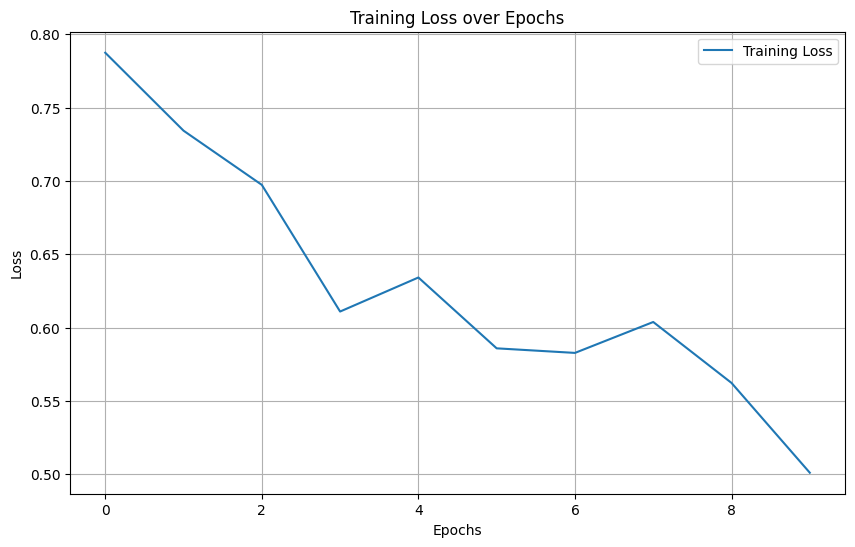

AUC measure: 0.8192743764172334


In [5]:
# Load and encode the data
encoder = DataEncoder(
    dataset_name="Handwritten",
    encoding_method="Amplitude",
    positive_label=0,
    num_train=100,
    num_test_pos=70,
    num_test_neg=70,
)

# Initialize the VQOCC circuit
nqubits = encoder.nqubits
ntrash = 2  # Number of trash qubits
layers = 3  # Number of layers
vqocc = VQOCCircuit(nqubits=nqubits, ntrash=ntrash, layers=layers)

# Train the circuit with verbose output
loss_history = vqocc.train(
    vector_train=encoder.vector_train, lr=0.1, nepochs=10, batch_size=10, verbose=True
)

# Draw the trained quantum circuit
vqocc.draw_circuit(encoder.vector_train[0])  # Use the first encoded input from training

# Plot the loss history
vqocc.plot_loss(loss_history)

# Evaluate AUC measure
auc_measure = vqocc.auc_test(encoder.vector_test_pos, encoder.vector_test_neg)
print(f"AUC measure: {auc_measure}")

GPU device setup failed, falling back to lightning.qubit (CPU)
Epoch 1/10, Loss: 1.0382438934960707
Epoch 2/10, Loss: 0.8670120959164904
Epoch 3/10, Loss: 0.8078089464198426
Epoch 4/10, Loss: 0.7381377136639706
Epoch 5/10, Loss: 0.6289687971297756
Epoch 6/10, Loss: 0.5843709153531298
Epoch 7/10, Loss: 0.4912752481933228
Epoch 8/10, Loss: 0.4310761964183797
Epoch 9/10, Loss: 0.38781915089666014
Epoch 10/10, Loss: 0.3620522793742128
0: ──RY(0.20)───RY(0.73)──RY(0.76)────────────┤  
1: ──RY(0.39)───RY(0.70)──RY(0.47)────────────┤  
2: ──RY(1.34)───RY(0.12)──RY(0.07)────────────┤  
3: ──RY(-0.63)──RY(0.16)──RY(-0.64)───────────┤  
4: ──RY(1.85)───RY(1.18)──RY(1.45)───RY(0.80)─┤  
5: ──RY(0.59)───RY(1.30)──RY(0.47)───RY(1.26)─┤  


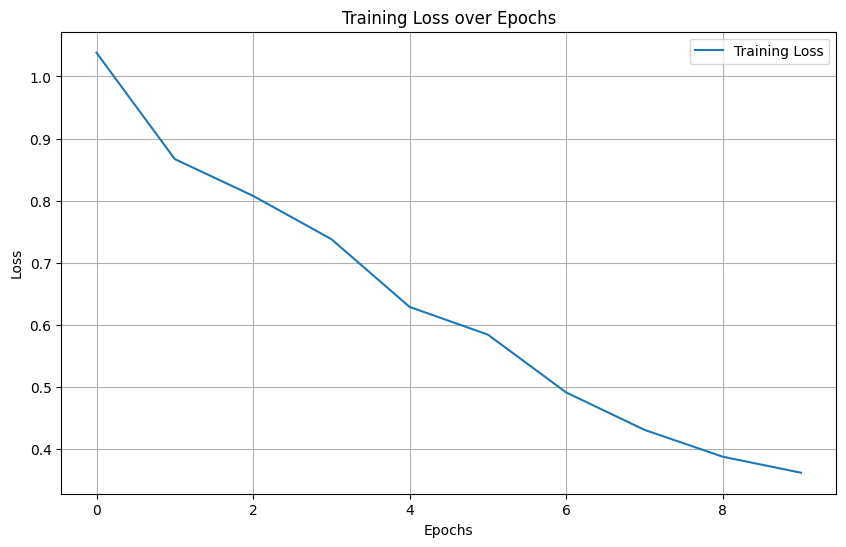

AUC measure: 0.9739002267573696


In [6]:
# Load and encode the data
encoder = DataEncoder(
    dataset_name="Handwritten",
    encoding_method="Amplitude",
    positive_label=0,
    num_train=100,
    num_test_pos=70,
    num_test_neg=70,
)

# Initialize the VQOCC circuit
nqubits = encoder.nqubits
ntrash = 2  # Number of trash qubits
layers = 3  # Number of layers
vqocc = VQOCCircuit(nqubits=nqubits, ntrash=ntrash, layers=layers)

# Train the circuit with verbose output
loss_history = vqocc.train(
    vector_train=encoder.vector_train, lr=0.1, nepochs=10, batch_size=10, verbose=True
)

# Draw the trained quantum circuit
vqocc.draw_circuit(encoder.vector_train[0])  # Use the first encoded input from training

# Plot the loss history
vqocc.plot_loss(loss_history)

# Evaluate AUC measure
auc_measure = vqocc.auc_test(encoder.vector_test_pos, encoder.vector_test_neg)
print(f"AUC measure: {auc_measure}")

GPU device setup failed, falling back to lightning.qubit (CPU)
Epoch 1/10, Loss: 0.9900646659824236
Epoch 2/10, Loss: 0.892818367847134
Epoch 3/10, Loss: 0.8210442660215505
Epoch 4/10, Loss: 0.7906203499889543
Epoch 5/10, Loss: 0.6900103839771606
Epoch 6/10, Loss: 0.6028383697260169
Epoch 7/10, Loss: 0.5183080897209329
Epoch 8/10, Loss: 0.430651816148022
Epoch 9/10, Loss: 0.400188738881403
Epoch 10/10, Loss: 0.32389487039795034
0: ──RY(-0.60)──RY(0.57)───RY(0.13)───RY(0.71)─────────────┤  
1: ──RY(0.70)───RY(0.96)───RY(-0.64)──RY(1.15)─────────────┤  
2: ──RY(1.54)───RY(0.05)───RY(-0.06)──RY(-0.16)────────────┤  
3: ──RY(-0.60)──RY(-0.13)──RY(1.29)───RY(-0.01)────────────┤  
4: ──RY(0.48)───RY(1.39)───RY(0.57)───RY(1.24)───RY(-0.30)─┤  
5: ──RY(-0.02)──RY(1.43)───RY(0.78)───RY(-0.45)──RY(1.52)──┤  


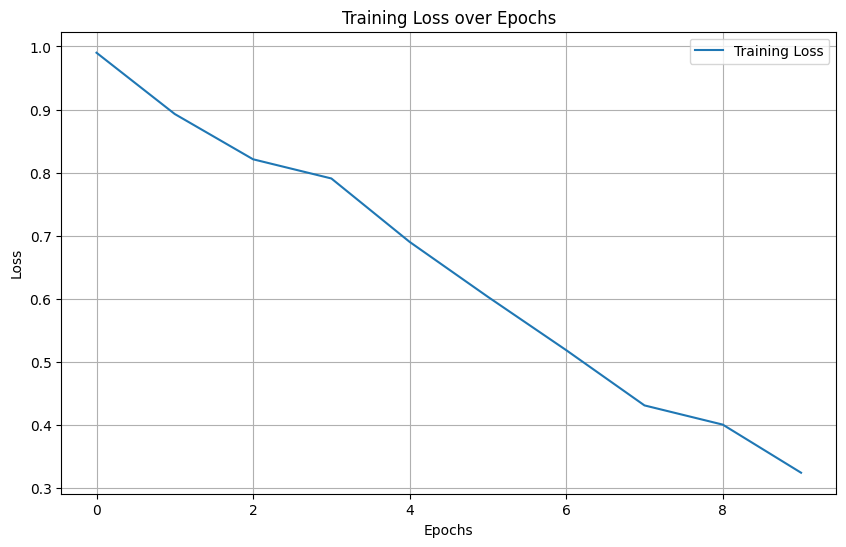

AUC measure: 0.9763038548752835


In [7]:
# Load and encode the data
encoder = DataEncoder(
    dataset_name="Handwritten",
    encoding_method="Amplitude",
    positive_label=0,
    num_train=100,
    num_test_pos=70,
    num_test_neg=70,
)

# Initialize the VQOCC circuit
nqubits = encoder.nqubits
ntrash = 2  # Number of trash qubits
layers = 4  # Number of layers
vqocc = VQOCCircuit(nqubits=nqubits, ntrash=ntrash, layers=layers)

# Train the circuit with verbose output
loss_history = vqocc.train(
    vector_train=encoder.vector_train, lr=0.1, nepochs=10, batch_size=10, verbose=True
)

# Draw the trained quantum circuit
vqocc.draw_circuit(encoder.vector_train[0])  # Use the first encoded input from training

# Plot the loss history
vqocc.plot_loss(loss_history)

# Evaluate AUC measure
auc_measure = vqocc.auc_test(encoder.vector_test_pos, encoder.vector_test_neg)
print(f"AUC measure: {auc_measure}")

Num GPUs Available: 1
GPU device setup failed, falling back to lightning.qubit (CPU)
Epoch 1/20, Loss: 0.6687075061668866
Epoch 2/20, Loss: 0.59807710481977
Epoch 3/20, Loss: 0.49166278451911055
Epoch 4/20, Loss: 0.41953769497851673
Epoch 5/20, Loss: 0.34259472244406125
Epoch 6/20, Loss: 0.2712457636224994
Epoch 7/20, Loss: 0.2166881254761451
Epoch 8/20, Loss: 0.12750697455878643
Epoch 9/20, Loss: 0.07114549114684832
Epoch 10/20, Loss: 0.03751983073390972
Epoch 11/20, Loss: 0.011823082309202527
Epoch 12/20, Loss: 0.004777980510708957
Epoch 13/20, Loss: 0.014699293663017499
Epoch 14/20, Loss: 0.03188314417488582
Epoch 15/20, Loss: 0.04575985403676702
Epoch 16/20, Loss: 0.06295567515307485
Epoch 17/20, Loss: 0.06834705812627559
Epoch 18/20, Loss: 0.07225394993778951
Epoch 19/20, Loss: 0.059583584175983764
Epoch 20/20, Loss: 0.05652352693539554
0: ──RY(2.04)───RY(1.90)───────────┤  
1: ──RY(-0.84)──RY(0.31)──RY(0.83)─┤  


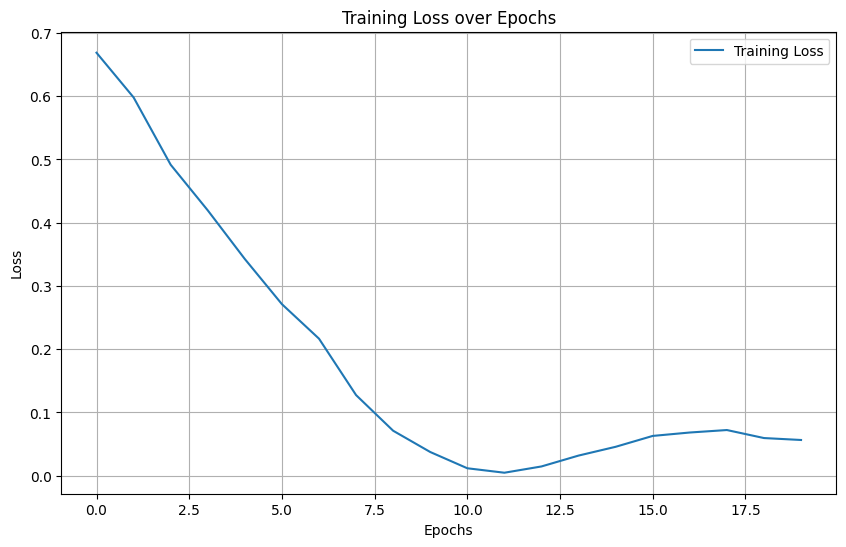

AUC measure: 1.0
Model parameters saved to vqocc_params.pkl


In [47]:
# Install required packages
!pip install -q pennylane scikit-learn matplotlib opencv-python tensorflow
!pip install -q pennylane-lightning-gpu

import os
import pickle
import cv2
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import load_digits, load_iris
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import tensorflow as tf
from itertools import combinations
from typing import List, Tuple, Union

# Check GPU availability
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

class DataEncoder:
    def __init__(
        self,
        dataset_name: str,
        encoding_method: str,
        positive_label: Union[int, str],
        num_train: int = 100,
        num_test_pos: int = 70,
        num_test_neg: int = 70,
    ):
        """
        DataEncoder class to handle data loading and encoding.

        Args:
            dataset_name (str): Name of the dataset ("Handwritten", "FMNIST", "Iris").
            encoding_method (str): Encoding method ("Amplitude" or "FRQI").
            positive_label (int or str): Label of the positive class for one-class classification.
            num_train (int): Number of positive samples for training.
            num_test_pos (int): Number of positive samples for testing.
            num_test_neg (int): Number of negative samples per class for testing.
        """
        self.dataset_name = dataset_name
        self.encoding_method = encoding_method
        self.positive_label = positive_label
        self.num_train = num_train
        self.num_test_pos = num_test_pos
        self.num_test_neg = num_test_neg
        self.nqubits = None

        self.vector_train = []
        self.vector_test_pos = []
        self.vector_test_neg = []

        self.load_and_encode_data()

    def load_and_encode_data(self):
        if self.dataset_name == "Handwritten":
            data, labels = self.load_handwritten_data()
        elif self.dataset_name == "FMNIST":
            data, labels = self.load_fmnist_data()
        elif self.dataset_name == "Iris":
            data, labels = self.load_iris_data()
        else:
            raise ValueError("Supported datasets are 'Handwritten', 'FMNIST', and 'Iris'.")

        self.nqubits = int(np.ceil(np.log2(data.shape[1])))

        # Process and encode data
        self.process_and_encode_data(data, labels)

    def load_handwritten_data(self) -> Tuple[np.ndarray, np.ndarray]:
        digits = load_digits()
        data = digits.data / 16.0  # Normalize data to [0,1]
        labels = digits.target
        return data, labels

    def load_fmnist_data(self) -> Tuple[np.ndarray, np.ndarray]:
        fashion_mnist = tf.keras.datasets.fashion_mnist
        (x_train, y_train), _ = fashion_mnist.load_data()
        x_train = x_train / 255.0  # Normalize data to [0,1]
        x_train = x_train.reshape((-1, 28 * 28))
        data = x_train
        labels = y_train
        return data, labels

    def load_iris_data(self) -> Tuple[np.ndarray, np.ndarray]:
        iris = load_iris()
        data = iris.data  # Features are already scaled appropriately
        labels = iris.target
        return data, labels

    def process_and_encode_data(self, data: np.ndarray, labels: np.ndarray):
        # Get positive and negative samples
        positive_indices = np.where(labels == self.positive_label)[0]
        negative_labels = np.delete(np.unique(labels), self.positive_label)
        negative_indices = np.where(np.isin(labels, negative_labels))[0]

        # Ensure we have enough samples
        num_train = min(self.num_train, len(positive_indices))
        num_test_pos = min(self.num_test_pos, len(positive_indices) - num_train)
        num_test_neg = min(self.num_test_neg, len(negative_indices) // len(negative_labels))

        # Get training data (positive samples)
        idx_train = positive_indices[:num_train]
        data_train = data[idx_train]

        # Get positive test data
        idx_test_pos = positive_indices[num_train:num_train + num_test_pos]
        data_test_pos = data[idx_test_pos]

        # Get negative test data
        data_test_neg = []
        for neg_label in negative_labels:
            neg_idx = np.where(labels == neg_label)[0][:num_test_neg]
            data_test_neg.append(data[neg_idx])
        data_test_neg = np.vstack(data_test_neg)

        # Resize images if necessary
        if self.dataset_name in ["FMNIST", "Handwritten"]:
            data_train = self.resize_images(data_train)
            data_test_pos = self.resize_images(data_test_pos)
            data_test_neg = self.resize_images(data_test_neg)

        # Encode data
        self.vector_train = self.encode_data(data_train)
        self.vector_test_pos = self.encode_data(data_test_pos)
        self.vector_test_neg = self.encode_data(data_test_neg)

    def resize_images(self, data: np.ndarray) -> np.ndarray:
        target_size = int(2 ** np.ceil(np.log2(np.sqrt(data.shape[1]))))
        resized_data = []
        for sample in data:
            img_size = int(np.sqrt(len(sample)))
            img = sample.reshape(img_size, img_size)
            resized_img = cv2.resize(img, dsize=(target_size, target_size), interpolation=cv2.INTER_CUBIC)
            resized_data.append(resized_img.flatten())
        return np.array(resized_data)

    def encode_data(self, data: np.ndarray) -> List[np.ndarray]:
        if self.encoding_method == "Amplitude":
            return self.amplitude_encoding(data)
        elif self.encoding_method == "FRQI":
            return self.frqi_encoding(data)
        else:
            raise ValueError("Supported encodings are 'Amplitude' and 'FRQI'.")

    def amplitude_encoding(self, data: np.ndarray) -> List[np.ndarray]:
        # Normalize each data sample
        normalized_data = [sample / np.linalg.norm(sample) for sample in data]
        return normalized_data

    def frqi_encoding(self, data: np.ndarray) -> List[np.ndarray]:
        encoded_data = []
        for sample in data:
            sample = sample.flatten()
            cos_component = np.cos(np.pi / 2 * sample)
            sin_component = np.sin(np.pi / 2 * sample)
            vector = np.concatenate((cos_component, sin_component))
            vector = vector / np.linalg.norm(vector)
            encoded_data.append(vector)
        return encoded_data

class VQOCCircuit:
    def __init__(self, nqubits: int, ntrash: int, layers: int):
        """
        Variational Quantum One-Class Classifier (VQOCC).

        Args:
            nqubits (int): Total number of qubits.
            ntrash (int): Number of trash qubits.
            layers (int): Number of layers in the variational circuit.
        """
        assert ntrash < nqubits, "Number of trash qubits must be less than total qubits."

        self.nqubits = nqubits
        self.ntrash = ntrash
        self.layers = layers

        self.trash_qubits = list(range(nqubits - ntrash, nqubits))
        self.non_trash_qubits = list(range(nqubits - ntrash))

        # Initialize parameters
        self.nparams = self.calculate_num_params()
        self.params = np.random.uniform(size=self.nparams, requires_grad=True)

        # Set up the quantum device
        try:
            self.dev = qml.device("lightning.gpu", wires=nqubits)
            print("Using GPU device")
        except Exception:
            print("GPU device setup failed, falling back to lightning.qubit (CPU)")
            self.dev = qml.device("lightning.qubit", wires=nqubits)

    def calculate_num_params(self) -> int:
        # Number of parameters depends on the architecture
        nparams = self.layers * self.nqubits + self.ntrash
        return nparams

    def circuit(self, params: np.ndarray, input_state: np.ndarray = None):
        @qml.qnode(self.dev, interface="autograd")
        def circuit_qnode(params):
            # Prepare the input state
            if input_state is not None:
                qml.QubitStateVector(input_state, wires=range(self.nqubits))
            else:
                for q in range(self.nqubits):
                    qml.Hadamard(wires=q)

            # Apply variational circuit
            idx_param = 0

            for _ in range(self.layers):
                # Apply rotations
                for q in range(self.nqubits):
                    qml.RY(params[idx_param], wires=q)
                    idx_param += 1

                # Apply entangling gates
                self.apply_entangling_gates()

            # Final rotations on trash qubits
            for q in self.trash_qubits:
                qml.RY(params[idx_param], wires=q)
                idx_param += 1

            # Measure expectation values
            exp_vals = [qml.expval(qml.PauliZ(wires=i)) for i in self.trash_qubits]
            return exp_vals

        return circuit_qnode(params)

    def apply_entangling_gates(self):
        # Apply CZ between all pairs of trash qubits
        for i, j in combinations(self.trash_qubits, 2):
            qml.CZ(wires=[i, j])

        # Apply CZ between trash and non-trash qubits
        for t in self.trash_qubits:
            for nt in self.non_trash_qubits:
                qml.CZ(wires=[t, nt])

    def cost_fn(self, params: np.ndarray, input_state: np.ndarray) -> float:
        exp_vals = self.circuit(params, input_state)
        cost = 0.5 * (self.ntrash - np.sum(exp_vals))
        return cost

    def train(
        self,
        vector_train: List[np.ndarray],
        lr: float = 0.1,
        nepochs: int = 150,
        batch_size: int = 10,
        verbose: bool = False,
    ) -> List[float]:
        """
        Train the VQOCC circuit.

        Args:
            vector_train (list): List of training data vectors.
            lr (float): Learning rate.
            nepochs (int): Number of epochs.
            batch_size (int): Batch size.
            verbose (bool): If True, print loss every epoch.

        Returns:
            list: Loss history over epochs.
        """
        optimizer = qml.AdamOptimizer(stepsize=lr)
        params = self.params
        loss_history = []

        for ep in range(nepochs):
            # Sample a batch
            batch_indices = np.random.randint(0, len(vector_train), (batch_size,))
            vector_batch = [vector_train[i] for i in batch_indices]

            def cost_fn_batch(params):
                cost = 0
                for input_state in vector_batch:
                    cost += self.cost_fn(params, input_state)
                return cost / batch_size

            params = optimizer.step(cost_fn_batch, params)
            loss = cost_fn_batch(params)
            loss_history.append(loss)

            if verbose:
                print(f"Epoch {ep + 1}/{nepochs}, Loss: {loss}")

        self.params = params
        return loss_history

    def plot_loss(self, loss_history: List[float]):
        """Plot the loss history."""
        plt.figure(figsize=(10, 6))
        plt.plot(loss_history, label="Training Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss over Epochs")
        plt.legend()
        plt.grid(True)
        plt.show()

    def draw_circuit(self, input_state=None):
        """
        Draw the trained quantum circuit using the current parameters with actual input data.

        Args:
            input_state (np.ndarray): Input data in quantum state format (already encoded).
                                      If None, use the first encoded training vector.
        """
        if input_state is None:
            # If no input is provided, use the first training vector as default input
            input_state = self.vector_train[0]  # Ensure this is the correct format for your model

        # Draw the final quantum circuit with the trained parameters and actual data
        drawer = qml.draw(self.circuit)
        print(drawer(self.params, input_state))

    def auc_test(self, vector_test_pos: List[np.ndarray], vector_test_neg: List[np.ndarray]) -> float:
        """
        Evaluate the AUC measure on test data.

        Args:
            vector_test_pos (list): List of positive test data vectors.
            vector_test_neg (list): List of negative test data vectors.

        Returns:
            float: AUC measure.
        """
        cost_pos = [self.cost_fn(self.params, input_state) for input_state in vector_test_pos]
        cost_neg = [self.cost_fn(self.params, input_state) for input_state in vector_test_neg]

        y_true = np.array([0] * len(cost_pos) + [1] * len(cost_neg))
        y_score = np.array(cost_pos + cost_neg)
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_measure = auc(fpr, tpr)
        return auc_measure

    def save_parameters(self, filepath: str):
        """
        Save the model parameters to a file.

        Args:
            filepath (str): Path to the file where parameters will be saved.
        """
        with open(filepath, 'wb') as f:
            pickle.dump(self.params, f)
        print(f"Model parameters saved to {filepath}")

    def load_parameters(self, filepath: str):
        """
        Load model parameters from a file.

        Args:
            filepath (str): Path to the file from which parameters will be loaded.
        """
        with open(filepath, 'rb') as f:
            self.params = pickle.load(f)
        print(f"Model parameters loaded from {filepath}")

# Example usage with the Iris dataset
# Load and encode the data
encoder = DataEncoder(
    dataset_name="Iris",
    encoding_method="Amplitude",
    positive_label=0,  # Setosa
    num_train=30,
    num_test_pos=10,
    num_test_neg=10,
)

# Initialize the VQOCC circuit
nqubits = encoder.nqubits
ntrash = 1  # Number of trash qubits
layers = 2  # Number of layers
vqocc = VQOCCircuit(nqubits=nqubits, ntrash=ntrash, layers=layers)

# Train the circuit with verbose output
loss_history = vqocc.train(
    vector_train=encoder.vector_train, lr=0.1, nepochs=20, batch_size=5, verbose=True
)

# Draw the trained quantum circuit
vqocc.draw_circuit(encoder.vector_train[0])  # Use the first encoded input from training

# Plot the loss history
vqocc.plot_loss(loss_history)

# Evaluate AUC measure
auc_measure = vqocc.auc_test(encoder.vector_test_pos, encoder.vector_test_neg)
print(f"AUC measure: {auc_measure}")

# Save the model parameters
vqocc.save_parameters('vqocc_params.pkl')

# To load the parameters later:
# vqocc.load_parameters('vqocc_params.pkl')


Num GPUs Available: 1
GPU device setup failed, falling back to default.qubit (CPU)
Epoch 1/20, Loss: 0.824357458404015
Epoch 2/20, Loss: 0.7111445906699236
Epoch 3/20, Loss: 0.6261422069305075
Epoch 4/20, Loss: 0.5277579145265724
Epoch 5/20, Loss: 0.3725748038301203
Epoch 6/20, Loss: 0.21938692919152442
Epoch 7/20, Loss: 0.13098942313106207
Epoch 8/20, Loss: 0.042577027197164816
Epoch 9/20, Loss: 0.005773710953713829
Epoch 10/20, Loss: 0.006207275907648824
Epoch 11/20, Loss: 0.035258460936665334
Epoch 12/20, Loss: 0.07526055230170317
Epoch 13/20, Loss: 0.08588782150439116
Epoch 14/20, Loss: 0.11261868653283771
Epoch 15/20, Loss: 0.09403290456950289
Epoch 16/20, Loss: 0.07814067249173781
Epoch 17/20, Loss: 0.060050790982984645
Epoch 18/20, Loss: 0.036166681212799014
Epoch 19/20, Loss: 0.02652098134649039
Epoch 20/20, Loss: 0.011849642323362252



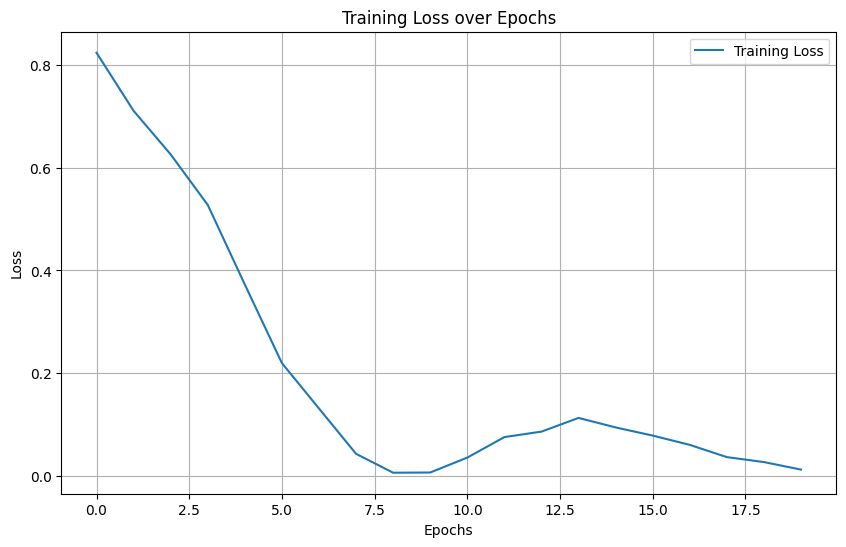

AUC measure: 1.0
Model parameters saved to vqocc_params.pkl


In [48]:
import os
import pickle
import cv2
import pennylane as qml
from pennylane import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import tensorflow as tf
from itertools import combinations
from typing import List, Tuple, Union

# Check GPU availability
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

class DataEncoder:
    def __init__(
        self,
        encoding_method: str,
        positive_label: Union[int, str],
        num_train: int = 100,
        num_test_pos: int = 70,
        num_test_neg: int = 70,
    ):
        """
        DataEncoder class to handle data loading and encoding.

        Args:
            encoding_method (str): Encoding method ("Amplitude" or "FRQI").
            positive_label (int or str): Label of the positive class for one-class classification.
            num_train (int): Number of positive samples for training.
            num_test_pos (int): Number of positive samples for testing.
            num_test_neg (int): Number of negative samples per class for testing.
        """
        self.encoding_method = encoding_method
        self.positive_label = positive_label
        self.num_train = num_train
        self.num_test_pos = num_test_pos
        self.num_test_neg = num_test_neg
        self.nqubits = None

        self.vector_train = []
        self.vector_test_pos = []
        self.vector_test_neg = []

    def load_data(self, data: np.ndarray, labels: np.ndarray):
        """
        Load and encode the data provided by the user.

        Args:
            data (np.ndarray): The feature data array of shape (num_samples, num_features).
            labels (np.ndarray): The labels array of shape (num_samples,).
        """
        self.data = data
        self.labels = labels

        self.n_features = data.shape[1]
        self.nqubits = int(np.ceil(np.log2(self.n_features)))

        # Process and encode data
        self.process_and_encode_data()

    def process_and_encode_data(self):
        # Get positive and negative samples
        positive_indices = np.where(self.labels == self.positive_label)[0]
        negative_labels = np.delete(np.unique(self.labels), self.positive_label)
        negative_indices = np.where(np.isin(self.labels, negative_labels))[0]

        # Ensure we have enough samples
        num_train = min(self.num_train, len(positive_indices))
        num_test_pos = min(self.num_test_pos, len(positive_indices) - num_train)
        num_test_neg = min(self.num_test_neg, len(negative_indices) // len(negative_labels))

        # Get training data (positive samples)
        idx_train = positive_indices[:num_train]
        data_train = self.data[idx_train]

        # Get positive test data
        idx_test_pos = positive_indices[num_train:num_train + num_test_pos]
        data_test_pos = self.data[idx_test_pos]

        # Get negative test data
        data_test_neg = []
        for neg_label in negative_labels:
            neg_idx = np.where(self.labels == neg_label)[0][:num_test_neg]
            data_test_neg.append(self.data[neg_idx])
        data_test_neg = np.vstack(data_test_neg)

        # Encode data
        self.vector_train = self.encode_data(data_train)
        self.vector_test_pos = self.encode_data(data_test_pos)
        self.vector_test_neg = self.encode_data(data_test_neg)

    def encode_data(self, data: np.ndarray) -> List[np.ndarray]:
        if self.encoding_method == "Amplitude":
            return self.amplitude_encoding(data)
        elif self.encoding_method == "FRQI":
            return self.frqi_encoding(data)
        else:
            raise ValueError("Supported encodings are 'Amplitude' and 'FRQI'.")

    def amplitude_encoding(self, data: np.ndarray) -> List[np.ndarray]:
        # Pad data to match the required number of features (2^nqubits)
        padded_data = []
        for sample in data:
            pad_size = 2 ** self.nqubits - len(sample)
            padded_sample = np.pad(sample, (0, pad_size), 'constant')
            # Normalize each data sample
            normalized_sample = padded_sample / np.linalg.norm(padded_sample)
            padded_data.append(normalized_sample)
        return padded_data

    def frqi_encoding(self, data: np.ndarray) -> List[np.ndarray]:
        # Similar padding as amplitude encoding
        encoded_data = []
        for sample in data:
            pad_size = 2 ** self.nqubits - len(sample)
            padded_sample = np.pad(sample, (0, pad_size), 'constant')
            cos_component = np.cos(np.pi / 2 * padded_sample)
            sin_component = np.sin(np.pi / 2 * padded_sample)
            vector = np.concatenate((cos_component, sin_component))
            vector = vector / np.linalg.norm(vector)
            encoded_data.append(vector)
        return encoded_data

class VQOCCircuit:
    def __init__(self, nqubits: int, ntrash: int, layers: int):
        """
        Variational Quantum One-Class Classifier (VQOCC).

        Args:
            nqubits (int): Total number of qubits.
            ntrash (int): Number of trash qubits.
            layers (int): Number of layers in the variational circuit.
        """
        assert ntrash < nqubits, "Number of trash qubits must be less than total qubits."

        self.nqubits = nqubits
        self.ntrash = ntrash
        self.layers = layers

        self.trash_qubits = list(range(nqubits - ntrash, nqubits))
        self.non_trash_qubits = list(range(nqubits - ntrash))

        # Initialize parameters
        self.nparams = self.calculate_num_params()
        self.params = np.random.uniform(size=self.nparams, requires_grad=True)

        # Set up the quantum device
        try:
            self.dev = qml.device("lightning.gpu", wires=nqubits)
            print("Using GPU device")
        except Exception:
            print("GPU device setup failed, falling back to default.qubit (CPU)")
            self.dev = qml.device("default.qubit", wires=nqubits)

    def calculate_num_params(self) -> int:
        # Number of parameters depends on the architecture
        nparams = self.layers * self.nqubits + self.ntrash
        return nparams

    def circuit(self, params: np.ndarray, input_state: np.ndarray = None):
        @qml.qnode(self.dev, interface="autograd")
        def circuit_qnode(params):
            # Prepare the input state
            if input_state is not None:
                qml.QubitStateVector(input_state, wires=range(self.nqubits))
            else:
                for q in range(self.nqubits):
                    qml.Hadamard(wires=q)

            # Apply variational circuit
            idx_param = 0

            for _ in range(self.layers):
                # Apply rotations
                for q in range(self.nqubits):
                    qml.RY(params[idx_param], wires=q)
                    idx_param += 1

                # Apply entangling gates
                self.apply_entangling_gates()

            # Final rotations on trash qubits
            for q in self.trash_qubits:
                qml.RY(params[idx_param], wires=q)
                idx_param += 1

            # Measure expectation values
            exp_vals = [qml.expval(qml.PauliZ(wires=i)) for i in self.trash_qubits]
            return exp_vals

        return circuit_qnode(params)

    def apply_entangling_gates(self):
        # Apply CZ between all pairs of trash qubits
        for i, j in combinations(self.trash_qubits, 2):
            qml.CZ(wires=[i, j])

        # Apply CZ between trash and non-trash qubits
        for t in self.trash_qubits:
            for nt in self.non_trash_qubits:
                qml.CZ(wires=[t, nt])

    def cost_fn(self, params: np.ndarray, input_state: np.ndarray) -> float:
        exp_vals = self.circuit(params, input_state)
        cost = 0.5 * (self.ntrash - np.sum(exp_vals))
        return cost

    def train(
        self,
        vector_train: List[np.ndarray],
        lr: float = 0.1,
        nepochs: int = 150,
        batch_size: int = 10,
        verbose: bool = False,
    ) -> List[float]:
        """
        Train the VQOCC circuit.

        Args:
            vector_train (list): List of training data vectors.
            lr (float): Learning rate.
            nepochs (int): Number of epochs.
            batch_size (int): Batch size.
            verbose (bool): If True, print loss every epoch.

        Returns:
            list: Loss history over epochs.
        """
        optimizer = qml.AdamOptimizer(stepsize=lr)
        params = self.params
        loss_history = []

        for ep in range(nepochs):
            # Sample a batch
            batch_indices = np.random.randint(0, len(vector_train), (batch_size,))
            vector_batch = [vector_train[i] for i in batch_indices]

            def cost_fn_batch(params):
                cost = 0
                for input_state in vector_batch:
                    cost += self.cost_fn(params, input_state)
                return cost / batch_size

            params = optimizer.step(cost_fn_batch, params)
            loss = cost_fn_batch(params)
            loss_history.append(loss)

            if verbose:
                print(f"Epoch {ep + 1}/{nepochs}, Loss: {loss}")

        self.params = params
        return loss_history

    def plot_loss(self, loss_history: List[float]):
        """Plot the loss history."""
        plt.figure(figsize=(10, 6))
        plt.plot(loss_history, label="Training Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss over Epochs")
        plt.legend()
        plt.grid(True)
        plt.show()

    def draw_circuit(self, input_state=None):
        """
        Draw the trained quantum circuit using the current parameters with actual input data.

        Args:
            input_state (np.ndarray): Input data in quantum state format (already encoded).
                                      If None, use the first encoded training vector.
        """
        if input_state is None:
            input_state = self.vector_train[0]

        # Draw the final quantum circuit with the trained parameters and actual data
        drawer = qml.draw(self.circuit)
        print(drawer(self.params, input_state))

    def auc_test(self, vector_test_pos: List[np.ndarray], vector_test_neg: List[np.ndarray]) -> float:
        """
        Evaluate the AUC measure on test data.

        Args:
            vector_test_pos (list): List of positive test data vectors.
            vector_test_neg (list): List of negative test data vectors.

        Returns:
            float: AUC measure.
        """
        cost_pos = [self.cost_fn(self.params, input_state) for input_state in vector_test_pos]
        cost_neg = [self.cost_fn(self.params, input_state) for input_state in vector_test_neg]

        y_true = np.array([0] * len(cost_pos) + [1] * len(cost_neg))
        y_score = np.array(cost_pos + cost_neg)
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_measure = auc(fpr, tpr)
        return auc_measure

    def save_parameters(self, filepath: str):
        """
        Save the model parameters to a file.

        Args:
            filepath (str): Path to the file where parameters will be saved.
        """
        with open(filepath, 'wb') as f:
            pickle.dump(self.params, f)
        print(f"Model parameters saved to {filepath}")

    def load_parameters(self, filepath: str):
        """
        Load model parameters from a file.

        Args:
            filepath (str): Path to the file from which parameters will be loaded.
        """
        with open(filepath, 'rb') as f:
            self.params = pickle.load(f)
        print(f"Model parameters loaded from {filepath}")

# Example usage with custom data

# Assume you have your own dataset
# Prepare your data in the required format
# data: NumPy array of shape (num_samples, num_features)
# labels: NumPy array of shape (num_samples,)

# For illustration, let's use the Iris dataset from scikit-learn
from sklearn.datasets import load_iris
iris = load_iris()
data = iris.data
labels = iris.target

# Normalize data if necessary
data = data / np.max(data, axis=0)

# Initialize the DataEncoder
encoder = DataEncoder(
    encoding_method="Amplitude",
    positive_label=0,  # Set the positive class label (e.g., class '0' for Iris setosa)
    num_train=30,
    num_test_pos=10,
    num_test_neg=10,
)

# Load your data into the encoder
encoder.load_data(data, labels)

# Initialize the VQOCC circuit
nqubits = encoder.nqubits
ntrash = 1  # Number of trash qubits
layers = 2  # Number of layers
vqocc = VQOCCircuit(nqubits=nqubits, ntrash=ntrash, layers=layers)

# Train the circuit with verbose output
loss_history = vqocc.train(
    vector_train=encoder.vector_train, lr=0.1, nepochs=20, batch_size=5, verbose=True
)

# Draw the trained quantum circuit
vqocc.draw_circuit(encoder.vector_train[0])  # Use the first encoded input from training

# Plot the loss history
vqocc.plot_loss(loss_history)

# Evaluate AUC measure
auc_measure = vqocc.auc_test(encoder.vector_test_pos, encoder.vector_test_neg)
print(f"AUC measure: {auc_measure}")

# Save the model parameters
vqocc.save_parameters('vqocc_params.pkl')

# To load the parameters later:
# vqocc.load_parameters('vqocc_params.pkl')


Num GPUs Available: 1

Running experiment on dataset: Iris
GPU device setup failed, falling back to default.qubit (CPU)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


AUC measure on Iris: nan


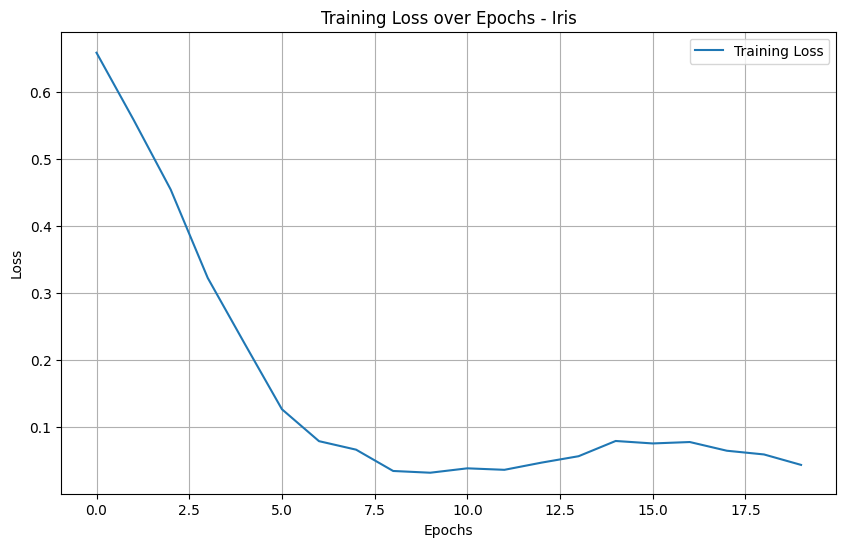

Model parameters saved to vqocc_params_Iris.pkl

Running experiment on dataset: Digits
GPU device setup failed, falling back to default.qubit (CPU)
AUC measure on Digits: 0.26916666666666667


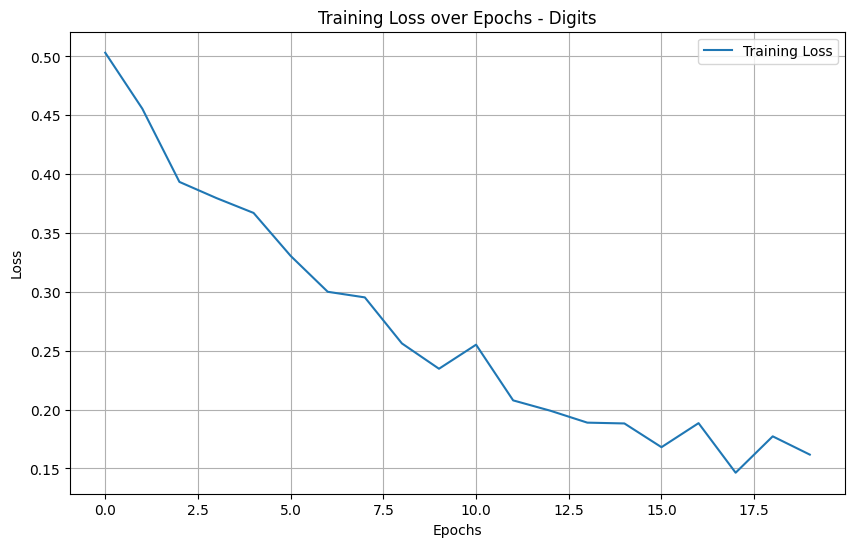

Model parameters saved to vqocc_params_Digits.pkl

Running experiment on dataset: Wine
GPU device setup failed, falling back to default.qubit (CPU)
AUC measure on Wine: 0.35


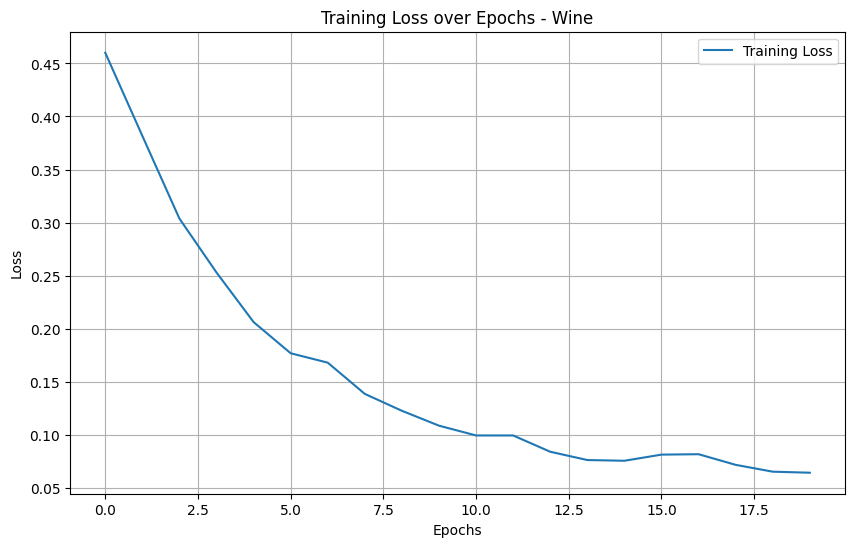

Model parameters saved to vqocc_params_Wine.pkl

Running experiment on dataset: BreastCancer
GPU device setup failed, falling back to default.qubit (CPU)
AUC measure on BreastCancer: 0.6675


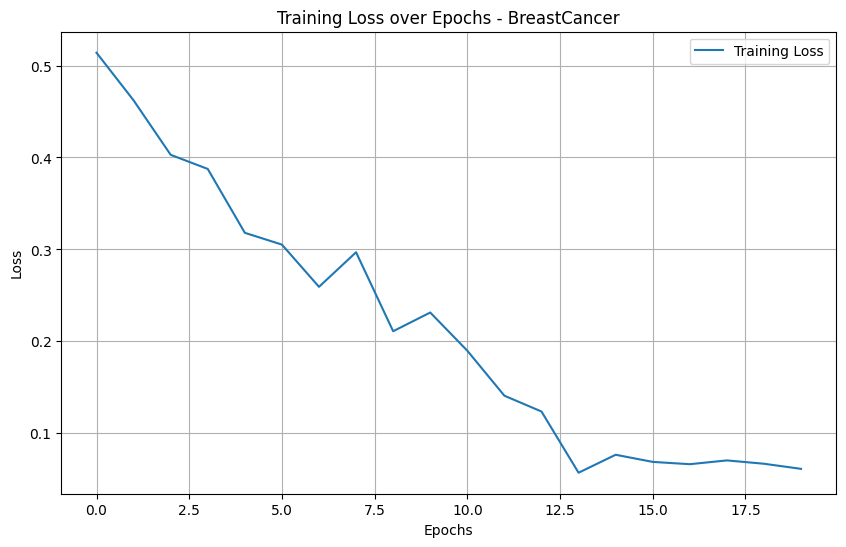

Model parameters saved to vqocc_params_BreastCancer.pkl

Running experiment on dataset: Diabetes
GPU device setup failed, falling back to default.qubit (CPU)
AUC measure on Diabetes: 0.54


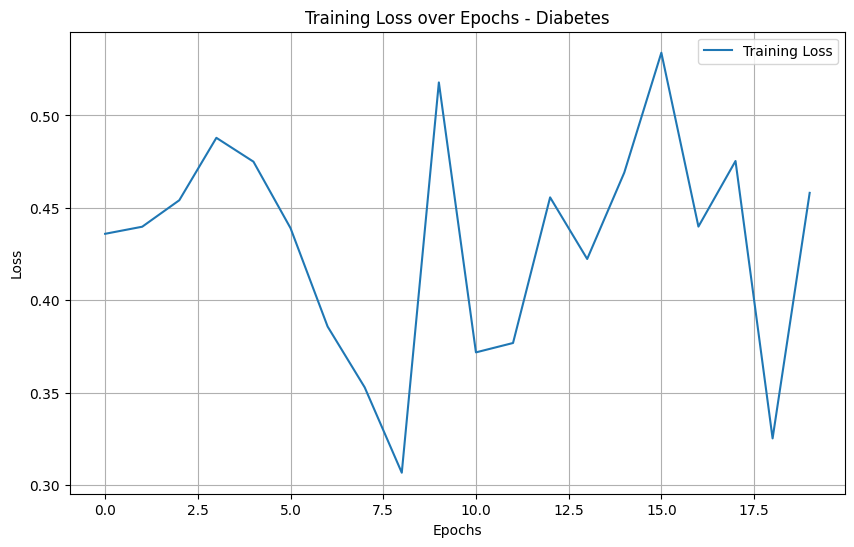

Model parameters saved to vqocc_params_Diabetes.pkl

Running experiment on dataset: Linnerud
GPU device setup failed, falling back to default.qubit (CPU)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


AUC measure on Linnerud: nan


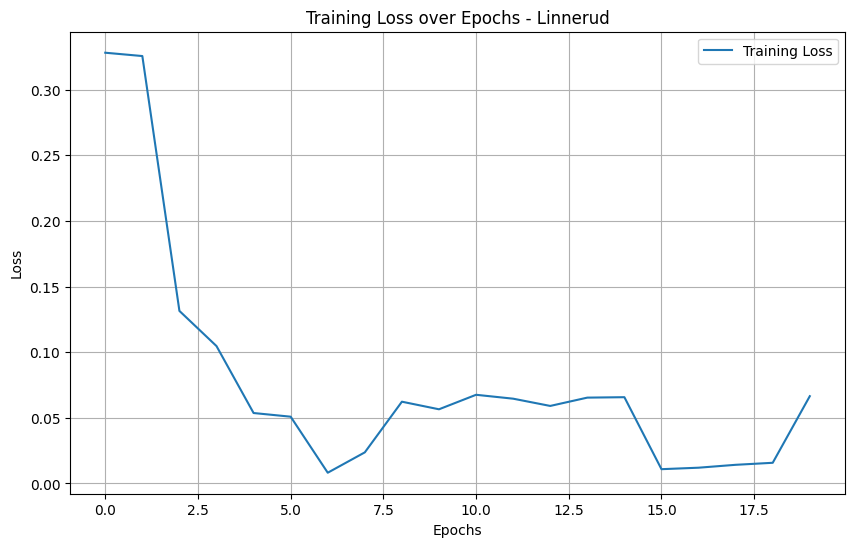

Model parameters saved to vqocc_params_Linnerud.pkl

Running experiment on dataset: BostonHousing


ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>


In [56]:
# # Install required packages
# !pip install -q pennylane scikit-learn matplotlib opencv-python tensorflow
# !pip install -q pennylane-lightning-gpu

import os
import pickle
import cv2
import pennylane as qml
from pennylane import numpy as np
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import tensorflow as tf
from itertools import combinations
from typing import List, Tuple, Union

# Check GPU availability
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

class DataEncoder:
    def __init__(
        self,
        encoding_method: str,
        positive_label: Union[int, str],
        num_train: int = 100,
        num_test_pos: int = 70,
        num_test_neg: int = 70,
    ):
        """
        DataEncoder class to handle data loading and encoding.

        Args:
            encoding_method (str): Encoding method ("Amplitude" or "FRQI").
            positive_label (int or str): Label of the positive class for one-class classification.
            num_train (int): Number of positive samples for training.
            num_test_pos (int): Number of positive samples for testing.
            num_test_neg (int): Number of negative samples per class for testing.
        """
        self.encoding_method = encoding_method
        self.positive_label = positive_label
        self.num_train = num_train
        self.num_test_pos = num_test_pos
        self.num_test_neg = num_test_neg
        self.nqubits = None

        self.vector_train = []
        self.vector_test_pos = []
        self.vector_test_neg = []

    def load_data(self, data: np.ndarray, labels: np.ndarray):
        """
        Load and encode the data provided by the user.

        Args:
            data (np.ndarray): The feature data array of shape (num_samples, num_features).
            labels (np.ndarray): The labels array of shape (num_samples,).
        """
        self.data = data
        self.labels = labels

        self.n_features = data.shape[1]
        self.nqubits = int(np.ceil(np.log2(self.n_features)))

        # Process and encode data
        self.process_and_encode_data()

    def process_and_encode_data(self):
        # Get positive and negative samples
        positive_indices = np.where(self.labels == self.positive_label)[0]
        negative_labels = np.delete(np.unique(self.labels), self.positive_label)
        negative_indices = np.where(np.isin(self.labels, negative_labels))[0]

        # Ensure we have enough samples
        num_train = min(self.num_train, len(positive_indices))
        num_test_pos = min(self.num_test_pos, len(positive_indices) - num_train)
        num_test_neg = min(self.num_test_neg, len(negative_indices) // len(negative_labels))

        # Get training data (positive samples)
        idx_train = positive_indices[:num_train]
        data_train = self.data[idx_train]

        # Get positive test data
        idx_test_pos = positive_indices[num_train:num_train + num_test_pos]
        data_test_pos = self.data[idx_test_pos]

        # Get negative test data
        data_test_neg = []
        for neg_label in negative_labels:
            neg_idx = np.where(self.labels == neg_label)[0][:num_test_neg]
            data_test_neg.append(self.data[neg_idx])
        data_test_neg = np.vstack(data_test_neg)

        # Encode data
        self.vector_train = self.encode_data(data_train)
        self.vector_test_pos = self.encode_data(data_test_pos)
        self.vector_test_neg = self.encode_data(data_test_neg)

    def encode_data(self, data: np.ndarray) -> List[np.ndarray]:
        if self.encoding_method == "Amplitude":
            return self.amplitude_encoding(data)
        elif self.encoding_method == "FRQI":
            return self.frqi_encoding(data)
        else:
            raise ValueError("Supported encodings are 'Amplitude' and 'FRQI'.")

    def amplitude_encoding(self, data: np.ndarray) -> List[np.ndarray]:
        # Pad data to match the required number of features (2^nqubits)
        padded_data = []
        for sample in data:
            pad_size = 2 ** self.nqubits - len(sample)
            padded_sample = np.pad(sample, (0, pad_size), 'constant')
            # Normalize each data sample
            normalized_sample = padded_sample / np.linalg.norm(padded_sample)
            padded_data.append(normalized_sample)
        return padded_data

    def frqi_encoding(self, data: np.ndarray) -> List[np.ndarray]:
        # Similar padding as amplitude encoding
        encoded_data = []
        for sample in data:
            pad_size = 2 ** self.nqubits - len(sample)
            padded_sample = np.pad(sample, (0, pad_size), 'constant')
            cos_component = np.cos(np.pi / 2 * padded_sample)
            sin_component = np.sin(np.pi / 2 * padded_sample)
            vector = np.concatenate((cos_component, sin_component))
            vector = vector / np.linalg.norm(vector)
            encoded_data.append(vector)
        return encoded_data

class VQOCCircuit:
    def __init__(self, nqubits: int, ntrash: int, layers: int):
        """
        Variational Quantum One-Class Classifier (VQOCC).

        Args:
            nqubits (int): Total number of qubits.
            ntrash (int): Number of trash qubits.
            layers (int): Number of layers in the variational circuit.
        """
        assert ntrash < nqubits, "Number of trash qubits must be less than total qubits."

        self.nqubits = nqubits
        self.ntrash = ntrash
        self.layers = layers

        self.trash_qubits = list(range(nqubits - ntrash, nqubits))
        self.non_trash_qubits = list(range(nqubits - ntrash))

        # Initialize parameters
        self.nparams = self.calculate_num_params()
        self.params = np.random.uniform(size=self.nparams, requires_grad=True)

        # Set up the quantum device
        try:
            self.dev = qml.device("lightning.gpu", wires=nqubits)
            print("Using GPU device")
        except Exception:
            print("GPU device setup failed, falling back to default.qubit (CPU)")
            self.dev = qml.device("default.qubit", wires=nqubits)

    def calculate_num_params(self) -> int:
        # Number of parameters depends on the architecture
        nparams = self.layers * self.nqubits + self.ntrash
        return nparams

    def circuit(self, params: np.ndarray, input_state: np.ndarray = None):
        @qml.qnode(self.dev, interface="autograd")
        def circuit_qnode(params):
            # Prepare the input state
            if input_state is not None:
                qml.QubitStateVector(input_state, wires=range(self.nqubits))
            else:
                for q in range(self.nqubits):
                    qml.Hadamard(wires=q)

            # Apply variational circuit
            idx_param = 0

            for _ in range(self.layers):
                # Apply rotations
                for q in range(self.nqubits):
                    qml.RY(params[idx_param], wires=q)
                    idx_param += 1

                # Apply entangling gates
                self.apply_entangling_gates()

            # Final rotations on trash qubits
            for q in self.trash_qubits:
                qml.RY(params[idx_param], wires=q)
                idx_param += 1

            # Measure expectation values
            exp_vals = [qml.expval(qml.PauliZ(wires=i)) for i in self.trash_qubits]
            return exp_vals

        return circuit_qnode(params)

    def apply_entangling_gates(self):
        # Apply CZ between all pairs of trash qubits
        for i, j in combinations(self.trash_qubits, 2):
            qml.CZ(wires=[i, j])

        # Apply CZ between trash and non-trash qubits
        for t in self.trash_qubits:
            for nt in self.non_trash_qubits:
                qml.CZ(wires=[t, nt])

    def cost_fn(self, params: np.ndarray, input_state: np.ndarray) -> float:
        exp_vals = self.circuit(params, input_state)
        cost = 0.5 * (self.ntrash - np.sum(exp_vals))
        return cost

    def train(
        self,
        vector_train: List[np.ndarray],
        lr: float = 0.1,
        nepochs: int = 150,
        batch_size: int = 10,
        verbose: bool = False,
    ) -> List[float]:
        """
        Train the VQOCC circuit.

        Args:
            vector_train (list): List of training data vectors.
            lr (float): Learning rate.
            nepochs (int): Number of epochs.
            batch_size (int): Batch size.
            verbose (bool): If True, print loss every epoch.

        Returns:
            list: Loss history over epochs.
        """
        optimizer = qml.AdamOptimizer(stepsize=lr)
        params = self.params
        loss_history = []

        for ep in range(nepochs):
            # Sample a batch
            batch_indices = np.random.randint(0, len(vector_train), (batch_size,))
            vector_batch = [vector_train[i] for i in batch_indices]

            def cost_fn_batch(params):
                cost = 0
                for input_state in vector_batch:
                    cost += self.cost_fn(params, input_state)
                return cost / batch_size

            params = optimizer.step(cost_fn_batch, params)
            loss = cost_fn_batch(params)
            loss_history.append(loss)

            if verbose:
                print(f"Epoch {ep + 1}/{nepochs}, Loss: {loss}")

        self.params = params
        return loss_history

    def plot_loss(self, loss_history: List[float], dataset_name: str):
        """Plot the loss history."""
        plt.figure(figsize=(10, 6))
        plt.plot(loss_history, label="Training Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"Training Loss over Epochs - {dataset_name}")
        plt.legend()
        plt.grid(True)
        plt.show()

    def draw_circuit(self, input_state=None):
        """
        Draw the trained quantum circuit using the current parameters with actual input data.

        Args:
            input_state (np.ndarray): Input data in quantum state format (already encoded).
                                      If None, use the first encoded training vector.
        """
        if input_state is None:
            input_state = self.vector_train[0]

        # Draw the final quantum circuit with the trained parameters and actual data
        drawer = qml.draw(self.circuit)
        print(drawer(self.params, input_state))

    def auc_test(self, vector_test_pos: List[np.ndarray], vector_test_neg: List[np.ndarray]) -> float:
        """
        Evaluate the AUC measure on test data.

        Args:
            vector_test_pos (list): List of positive test data vectors.
            vector_test_neg (list): List of negative test data vectors.

        Returns:
            float: AUC measure.
        """
        cost_pos = [self.cost_fn(self.params, input_state) for input_state in vector_test_pos]
        cost_neg = [self.cost_fn(self.params, input_state) for input_state in vector_test_neg]

        y_true = np.array([0] * len(cost_pos) + [1] * len(cost_neg))
        y_score = np.array(cost_pos + cost_neg)
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_measure = auc(fpr, tpr)
        return auc_measure

    def save_parameters(self, filepath: str):
        """
        Save the model parameters to a file.

        Args:
            filepath (str): Path to the file where parameters will be saved.
        """
        with open(filepath, 'wb') as f:
            pickle.dump(self.params, f)
        print(f"Model parameters saved to {filepath}")

    def load_parameters(self, filepath: str):
        """
        Load model parameters from a file.

        Args:
            filepath (str): Path to the file from which parameters will be loaded.
        """
        with open(filepath, 'rb') as f:
            self.params = pickle.load(f)
        print(f"Model parameters loaded from {filepath}")

# Function to load datasets
def load_dataset(name: str):
    """
    Load a dataset by name.

    Args:
        name (str): Name of the dataset.

    Returns:
        data (np.ndarray): Feature data.
        labels (np.ndarray): Labels.
    """
    if name == "Iris":
        iris = datasets.load_iris()
        data = iris.data
        labels = iris.target
    elif name == "Digits":
        digits = datasets.load_digits()
        data = digits.data / 16.0  # Normalize to [0,1]
        labels = digits.target
    elif name == "Wine":
        wine = datasets.load_wine()
        data = wine.data
        labels = wine.target
    elif name == "BreastCancer":
        bc = datasets.load_breast_cancer()
        data = bc.data
        labels = bc.target
    elif name == "Diabetes":
        diabetes = datasets.load_diabetes()
        data = diabetes.data
        labels = diabetes.target
        # For diabetes dataset, we'll binarize the target
        median = np.median(labels)
        labels = (labels > median).astype(int)
    elif name == "Linnerud":
        linnerud = datasets.load_linnerud()
        data = linnerud.data
        labels = linnerud.target[:, 0]  # Use one of the targets
        median = np.median(labels)
        labels = (labels > median).astype(int)
    elif name == "BostonHousing":
        boston = datasets.load_boston()
        data = boston.data
        labels = boston.target
        median = np.median(labels)
        labels = (labels > median).astype(int)
    elif name == "MNIST":
        # Use TensorFlow to load MNIST
        (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
        data = x_train.reshape(-1, 28 * 28) / 255.0
        labels = y_train
    elif name == "FashionMNIST":
        # Use TensorFlow to load Fashion MNIST
        (x_train, y_train), _ = tf.keras.datasets.fashion_mnist.load_data()
        data = x_train.reshape(-1, 28 * 28) / 255.0
        labels = y_train
    elif name == "OlivettiFaces":
        faces = datasets.fetch_olivetti_faces()
        data = faces.data
        labels = faces.target
    else:
        raise ValueError(f"Dataset '{name}' not recognized.")
    return data, labels

# List of datasets to run experiments on
datasets_list = [
    ("Iris", 0),
    ("Digits", 0),
    ("Wine", 0),
    ("BreastCancer", 0),
    ("Diabetes", 0),
    ("Linnerud", 0),
    ("BostonHousing", 0),
    ("MNIST", 0),
    ("FashionMNIST", 0),
    ("OlivettiFaces", 0),
]

# Run experiments on each dataset
results = {}

for dataset_name, positive_label in datasets_list:
    print(f"\nRunning experiment on dataset: {dataset_name}")
    # Load data
    data, labels = load_dataset(dataset_name)
    # Normalize data if necessary
    data = data.astype(np.float64)
    data = data / np.max(data, axis=0, where=(data != 0), initial=1)
    # Initialize the DataEncoder
    encoder = DataEncoder(
        encoding_method="Amplitude",
        positive_label=positive_label,  # Set the positive class label
        num_train=50,
        num_test_pos=20,
        num_test_neg=20,
    )
    # Load data into the encoder
    encoder.load_data(data, labels)
    # Initialize the VQOCCircuit
    nqubits = encoder.nqubits
    ntrash = max(1, nqubits // 4)  # Choose number of trash qubits
    layers = 2  # Number of layers
    vqocc = VQOCCircuit(nqubits=nqubits, ntrash=ntrash, layers=layers)
    # Train the circuit
    loss_history = vqocc.train(
        vector_train=encoder.vector_train, lr=0.1, nepochs=20, batch_size=5, verbose=False
    )
    # Evaluate AUC measure
    auc_measure = vqocc.auc_test(encoder.vector_test_pos, encoder.vector_test_neg)
    print(f"AUC measure on {dataset_name}: {auc_measure}")
    # Save the results
    results[dataset_name] = {
        "loss_history": loss_history,
        "auc": auc_measure,
        "nqubits": nqubits,
        "ntrash": ntrash,
        "layers": layers,
    }
    # Optionally plot the loss
    vqocc.plot_loss(loss_history, dataset_name)
    # Optionally save the model parameters
    model_filename = f'vqocc_params_{dataset_name}.pkl'
    vqocc.save_parameters(model_filename)

# Display the results
for dataset_name, result in results.items():
    print(f"Dataset: {dataset_name}, AUC: {result['auc']}, nqubits: {result['nqubits']}, ntrash: {result['ntrash']}")


In [ ]:
# Run experiments on each dataset
results = {}

for dataset_name, positive_label in datasets_list:
    print(f"\nRunning experiment on dataset: {dataset_name}")
    try:
        # Load data
        data, labels = load_dataset(dataset_name)
        print(f"Dataset: {dataset_name}, Data shape: {data.shape}, Labels shape: {labels.shape}")

        # Ensure data is two-dimensional
        if data.ndim == 1:
            data = data.reshape(-1, 1)

        # Normalize data if necessary
        data = data.astype(np.float64)
        max_values = np.max(data, axis=0, where=~np.isnan(data), initial=1)
        data = np.divide(data, max_values, where=max_values!=0)

        # Initialize the DataEncoder
        encoder = DataEncoder(
            encoding_method="Amplitude",
            positive_label=positive_label,  # Set the positive class label
            num_train=50,
            num_test_pos=20,
            num_test_neg=20,
        )
        # Load data into the encoder
        encoder.load_data(data, labels)